In [29]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti SUPER


In [31]:
df = pd.read_csv('../Data\Flight_Status_Predicition\Combined_Flights_2019.csv')

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\phamh\AppData\Local\Temp\ipykernel_30712\1851401122.py:1: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv('../Data\Flight_Status_Predicition\Combined_Flights_2019.csv')


In [32]:
df.shape

(8091684, 61)

In [33]:
df = df.dropna(subset=['DepDel15'])

non_delay = df[df['DepDel15'] == 0]
delay = df[df['DepDel15'] == 1]

total_samples = 1000000
df_sampled = df.sample(n=total_samples, random_state=42)

train_df, test_df = train_test_split(
    df_sampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_sampled['DepDel15']
)

df_balanced = df_sampled  

In [34]:
df_balanced['FlightDate'] = pd.to_datetime(df_balanced['FlightDate'])
df_balanced['dep_hour'] = pd.to_numeric(df_balanced['CRSDepTime'].astype(str).str.zfill(4).str[:2], errors='coerce')
df_balanced['arr_hour'] = pd.to_numeric(df_balanced['CRSArrTime'].astype(str).str.zfill(4).str[:2], errors='coerce')
df_balanced['month'] = df_balanced['FlightDate'].dt.month
df_balanced['day_of_week'] = df_balanced['FlightDate'].dt.dayofweek

num_features = ['Distance', 'dep_hour', 'arr_hour', 'month', 'day_of_week', 'CRSElapsedTime']
cat_features = ['Airline', 'Origin', 'Dest']  

features = num_features + cat_features
target = 'DepDel15'

df_clean = df_balanced[features + [target]].dropna()
print(f"Clean shape after feature eng: {df_clean.shape}")

Clean shape after feature eng: (1000000, 10)


In [35]:
le_airline = LabelEncoder()
le_origin = LabelEncoder()
le_dest = LabelEncoder()

df_clean['airline_enc'] = le_airline.fit_transform(df_clean['Airline'])
df_clean['origin_enc'] = le_origin.fit_transform(df_clean['Origin'])
df_clean['dest_enc'] = le_dest.fit_transform(df_clean['Dest'])

encoded_features = num_features + ['airline_enc', 'origin_enc', 'dest_enc']
X = df_clean[encoded_features].values
y = df_clean[target].values

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[:, :len(num_features)] = scaler.fit_transform(X[:, :len(num_features)])

print(f"Feature names: {encoded_features}")

Feature names: ['Distance', 'dep_hour', 'arr_hour', 'month', 'day_of_week', 'CRSElapsedTime', 'airline_enc', 'origin_enc', 'dest_enc']


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train delay ratio: {np.mean(y_train):.4f}, Test: {np.mean(y_test):.4f}")

Train: (800000, 9), Test: (200000, 9)
Train delay ratio: 0.1879, Test: 0.1879


In [37]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.FloatTensor(class_weights).to(device)


In [38]:
class_weights

tensor([0.6157, 2.6612], device='cuda:0')

In [39]:
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

batch_size = 1024  
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test: {len(test_loader)}")

Train batches: 782, Test: 196


In [40]:
class FlightDelayNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout=0.3):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_sizes:
            layers.extend([nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)])
            prev = h
        layers.append(nn.Linear(prev, 2)) 
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

input_size = X_train.shape[1]
model = FlightDelayNN(input_size).to(device)
print(model)
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

FlightDelayNN(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=2, bias=True)
  )
)
Params: 11,682


Epoch 5/20, Loss: 0.6702
Epoch 10/20, Loss: 0.6695
Epoch 15/20, Loss: 0.6694
Epoch 20/20, Loss: 0.6694


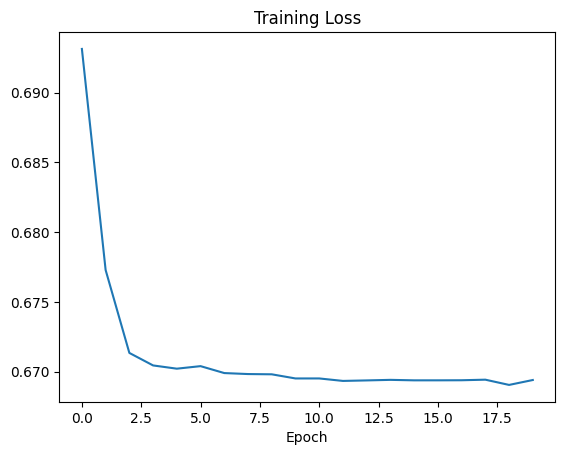

In [44]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
epochs = 20
train_losses = []
for epoch in range(epochs):
    loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(loss)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.show()


Test F1-Score: 0.3626

Full Report:
               precision    recall  f1-score   support

         0.0       0.88      0.50      0.63    162422
         1.0       0.24      0.70      0.36     37578

    accuracy                           0.54    200000
   macro avg       0.56      0.60      0.50    200000
weighted avg       0.76      0.54      0.58    200000



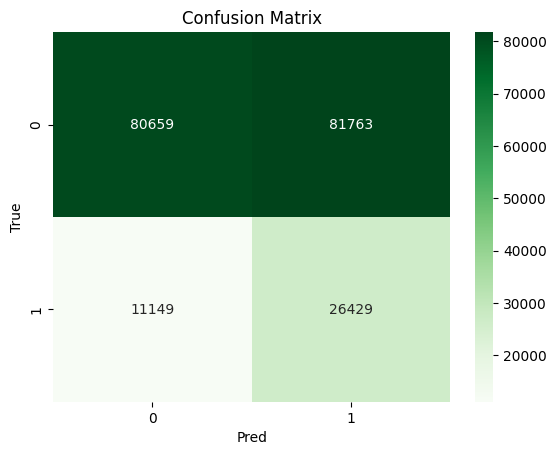

In [45]:
# Eval function
def evaluate(model, loader):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            _, pred = torch.max(outputs, 1)
            y_pred.extend(pred.cpu().numpy())
    return np.array(y_pred)

# Predict
y_pred = evaluate(model, test_loader)
f1 = f1_score(y_test, y_pred)
print(f"Test F1-Score: {f1:.4f}")
print("\nFull Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()